In [ ]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [ ]:
# MPC import - using LOCAL LinearMPC_3.1 folder
import numpy as np
from LinearMPC_3_1.MPCVelControl import MPCVelControl
from src.rocket import Rocket 
from src.vel_rocket_vis import RocketVis, plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [ ]:
# MPC parameters
Ts = 0.05       # Sampling time (20 Hz)
sim_time = 7.0  # Simulation time (should stabilize in < 7s)
H = 3.0         # MPC horizon (3 seconds)

# Create rocket and MPC controller
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl.new_controller(rocket, Ts, H)

print(f"MPC Controllers initialized:")
print(f"  Sampling time: {Ts}s")
print(f"  Horizon: {H}s ({int(H/Ts)} steps)")
print(f"  Simulation time: {sim_time}s")

**Test 1: Stabilize from 5 m/s in X direction**


In [ ]:
# Initial state: 5 m/s in x direction
# State vector: x = [wx, wy, wz, alpha, beta, gamma, vx, vy, vz, x, y, z]
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Run MPC simulation
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)

# Print results
print(f"\nTest 1 Results (5 m/s in x):")
print(f"  Initial state: vx={x0[6]:.2f} m/s")
print(f"  Final state:")
print(f"    vx={x_cl[6, -1]:.3f} m/s (should be ≈0)")
print(f"    vy={x_cl[7, -1]:.3f} m/s (should be ≈0)")
print(f"    vz={x_cl[8, -1]:.3f} m/s (should be ≈0)")
print(f"    beta={np.rad2deg(x_cl[4, -1]):.2f}° (should be < 10°)")
print(f"    alpha={np.rad2deg(x_cl[3, -1]):.2f}° (should be < 10°)")
print(f"  Position: x={x_cl[9, -1]:.2f}m, y={x_cl[10, -1]:.2f}m, z={x_cl[11, -1]:.2f}m")

# Visualize
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)

**Test 2: Stabilize from 5 m/s in Y direction**


In [ ]:
# Initial state: 5 m/s in y direction
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0])

# Run MPC simulation
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)

# Print results
print(f"\nTest 2 Results (5 m/s in y):")
print(f"  Initial state: vy={x0[7]:.2f} m/s")
print(f"  Final state:")
print(f"    vx={x_cl[6, -1]:.3f} m/s (should be ≈0)")
print(f"    vy={x_cl[7, -1]:.3f} m/s (should be ≈0)")
print(f"    vz={x_cl[8, -1]:.3f} m/s (should be ≈0)")
print(f"    beta={np.rad2deg(x_cl[4, -1]):.2f}° (should be < 10°)")
print(f"    alpha={np.rad2deg(x_cl[3, -1]):.2f}° (should be < 10°)")
print(f"  Position: x={x_cl[9, -1]:.2f}m, y={x_cl[10, -1]:.2f}m, z={x_cl[11, -1]:.2f}m")

# Visualize
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)

**Test 3: Stabilize from 5 m/s upward (Z direction)**

In [ ]:
# Initial state: 5 m/s upward (positive z)
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0])

# Run MPC simulation
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)

# Print results
print(f"\nTest 3 Results (5 m/s upward):")
print(f"  Initial state: vz={x0[8]:.2f} m/s")
print(f"  Final state:")
print(f"    vx={x_cl[6, -1]:.3f} m/s (should be ≈0)")
print(f"    vy={x_cl[7, -1]:.3f} m/s (should be ≈0)")
print(f"    vz={x_cl[8, -1]:.3f} m/s (should be ≈0)")
print(f"  Throttle range: Pavg ∈ [{u_cl[2, :].min():.1f}%, {u_cl[2, :].max():.1f}%] (should be [40, 80])")
print(f"  Position: x={x_cl[9, -1]:.2f}m, y={x_cl[10, -1]:.2f}m, z={x_cl[11, -1]:.2f}m")

# Visualize
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)

**Test 4: Roll Angle Tracking (gamma = 40°)**

In [ ]:
# Initial state: origin (all zeros)
x0 = np.zeros(12)

# Target state: gamma = 40°
# State vector: x = [wx, wy, wz, alpha, beta, gamma, vx, vy, vz, x, y, z]
x_target = np.zeros(12)
x_target[5] = np.deg2rad(40.0)  # gamma = 40° in radians

print("Test 5: Roll angle tracking (gamma = 40°)")
print(f"Initial state: gamma = {np.rad2deg(x0[5]):.2f}°")
print(f"Target state: gamma = {np.rad2deg(x_target[5]):.2f}°")

# Run MPC simulation with target tracking
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, x_target=x_target, method="linear"
)

# Print results
print(f"\nTest 5 Results (Roll 40°):")
print(f"  Initial gamma: {np.rad2deg(x0[5]):.2f}°")
print(f"  Target gamma: {np.rad2deg(x_target[5]):.2f}°")
print(f"  Final state:")
print(f"    gamma={np.rad2deg(x_cl[5, -1]):.2f}° (target: {np.rad2deg(x_target[5]):.2f}°)")
print(f"    wz={x_cl[2, -1]:.3f} rad/s (should be ≈0 at steady-state)")
print(f"    vx={x_cl[6, -1]:.3f} m/s (should be ≈0)")
print(f"    vy={x_cl[7, -1]:.3f} m/s (should be ≈0)")
print(f"    vz={x_cl[8, -1]:.3f} m/s (should be ≈0)")
print(f"  Tracking error: {np.rad2deg(x_cl[5, -1] - x_target[5]):.2f}°")

# Check maximum roll rate
wz_max = np.max(np.abs(x_cl[2, :]))
print(f"  Max roll rate: {wz_max:.3f} rad/s = {np.rad2deg(wz_max):.2f} °/s")

# Visualize
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_cl[:-1], 
    x_cl[:, :-1], 
    u_cl, 
    Ref=x_target.reshape(-1, 1).repeat(u_cl.shape[1], axis=1),
    T_ol=t_ol[..., :-1], 
    X_ol=x_ol, 
    U_ol=u_ol
)

**Test 5: Combined Initial Conditions**


In [ ]:
# Initial state: Combined disturbances
x0 = np.array([
    0.0,            # wx
    0.0,            # wy
    0.0,            # wz
    0.0,            # alpha
    0.0,            # beta
    np.pi * 30 / 180,     # gamma (30° roll)
    5.0,            # vx
    5.0,            # vy
    5.0,            # vz
    0.0,            # x
    0.0,            # y
    0.0             # z
])

sim = "CLOSED_LOOP"  # Change to "OPEN_LOOP" for open-loop simulation

if sim == "CLOSED_LOOP":
    print("Running CLOSED-LOOP simulation (MPC recalculates at each time step)...")
    # Use existing simulate_control function for closed-loop MPC
    t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
        mpc, sim_time, H, x0, method="linear"
    )
    
elif sim == "OPEN_LOOP":
    print("Running OPEN-LOOP simulation (control computed once at t=0, no feedback)...")
    
    # Compute optimal control sequence once at t=0
    u_first, x_pred, u_seq, t_pred = mpc.get_u(0.0, x0)
    
    # Extend control sequence to cover full simulation time
    N_sim = int(sim_time / Ts)
    N_horizon = u_seq.shape[1]
    
    print(f"  MPC horizon: {H}s ({N_horizon} steps)")
    print(f"  Simulation time: {sim_time}s ({N_sim} steps)")
    
    # Create extended control sequence: use MPC prediction, then hold last value
    U_extended = np.zeros((4, N_sim))
    if N_horizon <= N_sim:
        U_extended[:, :N_horizon] = u_seq
        U_extended[:, N_horizon:] = u_seq[:, -1:].repeat(N_sim - N_horizon, axis=1)
    else:
        U_extended = u_seq[:, :N_sim]
    
    # Simulate with fixed control sequence over full sim_time
    t_cl, x_cl, u_cl = rocket.simulate(x0, sim_time, U_extended, method="linear")
    
    # Create dummy variables for visualization
    t_ol, x_ol, u_ol = None, None, None
    ref = np.zeros((12, x_cl.shape[1]))
    
else:
    raise ValueError(f"Invalid sim type: {sim}. Choose 'CLOSED_LOOP' or 'OPEN_LOOP'")

# Print results
print(f"\nTest 5 Results (Combined - {sim}):")
print(f"  Initial state: vx={x0[6]:.1f}, vy={x0[7]:.1f}, vz={x0[8]:.1f} m/s, gamma={np.rad2deg(x0[5]):.1f}°")
print(f"  Final state:")
print(f"    vx={x_cl[6, -1]:.3f} m/s (should be ≈0)")
print(f"    vy={x_cl[7, -1]:.3f} m/s (should be ≈0)")
print(f"    vz={x_cl[8, -1]:.3f} m/s (should be ≈0)")
print(f"    gamma={np.rad2deg(x_cl[5, -1]):.3f}° (should be ≈0)")
print(f"    beta={np.rad2deg(x_cl[4, -1]):.2f}° (should be < 10°)")
print(f"    alpha={np.rad2deg(x_cl[3, -1]):.2f}° (should be < 10°)")
print(f"  Position: x={x_cl[9, -1]:.2f}m, y={x_cl[10, -1]:.2f}m, z={x_cl[11, -1]:.2f}m")
print(f"  Simulation duration: {t_cl[-1]:.2f}s")

# Visualize (adapt based on simulation type)
if sim == "CLOSED_LOOP" and t_ol is not None:
    vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol)
else:
    # Open-loop: adjust dimensions to avoid mismatch
    n_t = len(t_cl)
    n_x = x_cl.shape[1]
    n_u = u_cl.shape[1]
    n_plot = min(n_t, n_x, n_u)
    vis.animate(t_cl[:n_plot], x_cl[:, :n_plot], u_cl[:, :n_plot])

Running OPEN-LOOP simulation (control computed once at t=0, no feedback)...


c:\Users\maxim\miniconda3\envs\mpc2025\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


  MPC horizon: 3.0s (60 steps)
  Simulation time: 7.0s (140 steps)
Simulating time 0.00:
Simulating time 0.05:
Simulating time 0.10:
Simulating time 0.15:
Simulating time 0.20:
Simulating time 0.25:
Simulating time 0.30:
Simulating time 0.35:
Simulating time 0.40:
Simulating time 0.45:
Simulating time 0.50:
Simulating time 0.55:
Simulating time 0.60:
Simulating time 0.65:
Simulating time 0.70:
Simulating time 0.75:
Simulating time 0.80:
Simulating time 0.85:
Simulating time 0.90:
Simulating time 0.95:
Simulating time 1.00:
Simulating time 1.05:
Simulating time 1.10:
Simulating time 1.15:
Simulating time 1.20:
Simulating time 1.25:
Simulating time 1.30:
Simulating time 1.35:
Simulating time 1.40:
Simulating time 1.45:
Simulating time 1.50:
Simulating time 1.55:
Simulating time 1.60:
Simulating time 1.65:
Simulating time 1.70:
Simulating time 1.75:
Simulating time 1.80:
Simulating time 1.85:
Simulating time 1.90:
Simulating time 1.95:
Simulating time 2.00:
Simulating time 2.05:
Simulatin

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

ValueError: x and y must have same first dimension, but have shapes (139,) and (140,)

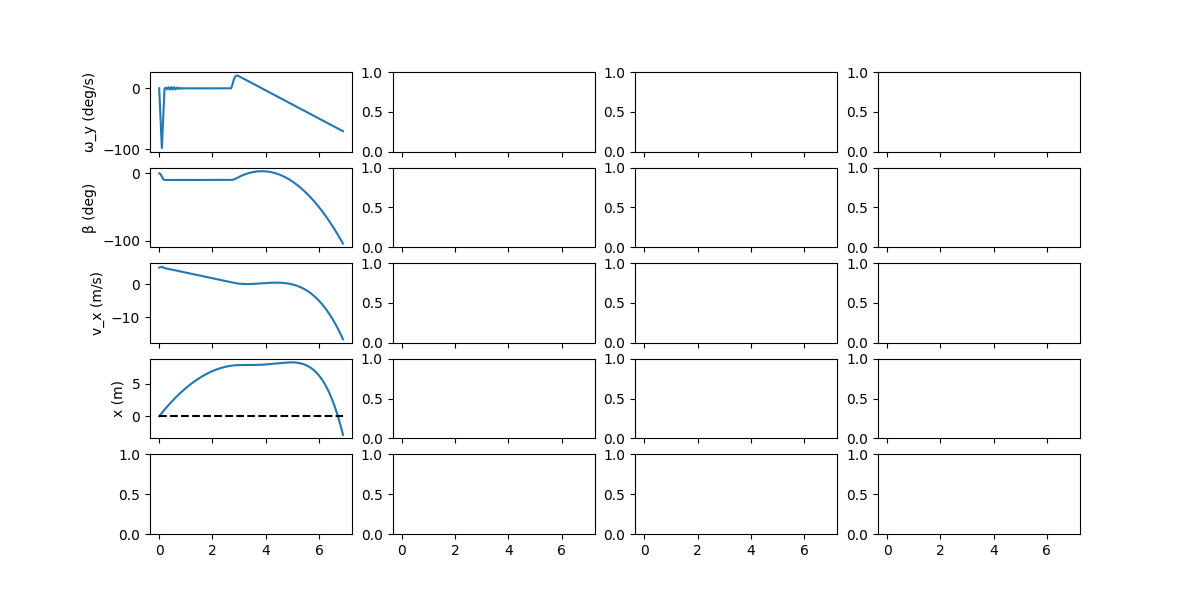

In [47]:
#Open
plot_static_states_inputs(t_cl[:-1], x_cl[:, :-1], u_cl, ref[:, :-1])

## Terminal Invariant Sets Visualization

In this section, we visualize the **terminal invariant sets (X_f)** for each subsystem controller.

### Design Methodology

The terminal invariant set X_f is computed for each MPC controller to ensure **recursive feasibility** and **stability**. For a given subsystem with dynamics `x+ = A*x + B*u`:

1. **Terminal Cost**: Computed using LQR: `P = dlqr(A, B, Q, R)` where Q and R are the MPC weighting matrices
2. **Terminal Controller**: `u = K_f * x` where `K_f` is the LQR feedback gain
3. **Closed-loop System**: `x+ = (A + B*K_f) * x = A_cl * x`
4. **Invariant Set**: The maximal positively invariant set for `A_cl` subject to state and input constraints

### Tuning Parameters Impact

Each controller uses different **Q** and **R** matrices that directly affect X_f:

- **Larger Q penalties** → Faster convergence but smaller X_f (more aggressive state regulation)
- **Larger R penalties** → Slower, smoother control but potentially larger X_f (less control authority)
- **Tighter constraints** → Smaller X_f (more restrictive operating region)

The terminal set must satisfy:
- `x ∈ X_f` ⟹ `K_f*x` respects input constraints
- `x ∈ X_f` ⟹ `A_cl*x ∈ X_f` (positive invariance)

Below we show 2D projections of each subsystem's terminal invariant set.

In [ ]:
import matplotlib.pyplot as plt

# Access the terminal invariant sets from each controller
X_f_xvel = mpc.mpc_xvel.X_f  # X velocity controller: [wy, beta, vx]
X_f_yvel = mpc.mpc_yvel.X_f  # Y velocity controller: [wx, alpha, vy]
X_f_zvel = mpc.mpc_zvel.X_f  # Z velocity controller: [vz]
X_f_roll = mpc.mpc_roll.X_f  # Roll controller: [wz, gamma]

# Softer blue color for plots (less harsh on eyes)
plot_color = 'steelblue'
fill_color = 'lightsteelblue'

# Create figure with subplots for all projections
fig = plt.figure(figsize=(16, 12))

# ========== X Velocity Controller (3D: wy, beta, vx) ==========
# State names for X controller
state_names_x = ['wy [rad/s]', 'beta [rad]', 'vx [m/s]']

# Plot all 3 2D projections
ax1 = fig.add_subplot(3, 3, 1)
X_f_xvel.projection(dims=(0, 1)).plot(ax1, color=plot_color, opacity=0.3, edge_color=plot_color, edge_width=1.5)
ax1.set_xlabel(state_names_x[0])
ax1.set_ylabel(state_names_x[1])
ax1.set_title('X-Vel: (wy, beta) projection')
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(3, 3, 2)
X_f_xvel.projection(dims=(0, 2)).plot(ax2, color=plot_color, opacity=0.3, edge_color=plot_color, edge_width=1.5)
ax2.set_xlabel(state_names_x[0])
ax2.set_ylabel(state_names_x[2])
ax2.set_title('X-Vel: (wy, vx) projection')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(3, 3, 3)
X_f_xvel.projection(dims=(1, 2)).plot(ax3, color=plot_color, opacity=0.3, edge_color=plot_color, edge_width=1.5)
ax3.set_xlabel(state_names_x[1])
ax3.set_ylabel(state_names_x[2])
ax3.set_title('X-Vel: (beta, vx) projection')
ax3.grid(True, alpha=0.3)

# ========== Y Velocity Controller (3D: wx, alpha, vy) ==========
state_names_y = ['wx [rad/s]', 'alpha [rad]', 'vy [m/s]']

ax4 = fig.add_subplot(3, 3, 4)
X_f_yvel.projection(dims=(0, 1)).plot(ax4, color=plot_color, opacity=0.3, edge_color=plot_color, edge_width=1.5)
ax4.set_xlabel(state_names_y[0])
ax4.set_ylabel(state_names_y[1])
ax4.set_title('Y-Vel: (wx, alpha) projection')
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(3, 3, 5)
X_f_yvel.projection(dims=(0, 2)).plot(ax5, color=plot_color, opacity=0.3, edge_color=plot_color, edge_width=1.5)
ax5.set_xlabel(state_names_y[0])
ax5.set_ylabel(state_names_y[2])
ax5.set_title('Y-Vel: (wx, vy) projection')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(3, 3, 6)
X_f_yvel.projection(dims=(1, 2)).plot(ax6, color=plot_color, opacity=0.3, edge_color=plot_color, edge_width=1.5)
ax6.set_xlabel(state_names_y[1])
ax6.set_ylabel(state_names_y[2])
ax6.set_title('Y-Vel: (alpha, vy) projection')
ax6.grid(True, alpha=0.3)

# ========== Z Velocity Controller (1D: vz) ==========
ax7 = fig.add_subplot(3, 3, 7)
# For 1D, extract bounds from the Polyhedron
# X_f_zvel is 1D, so we can get its bounds from H-representation
H_mat = X_f_zvel.H
b_vec = X_f_zvel.b
# For 1D: H*x <= b gives us bounds
# Typically: [1; -1] * vz <= [vz_max; -vz_min]
vz_min = -b_vec[1] if len(b_vec) > 1 else -b_vec[0]
vz_max = b_vec[0]

ax7.plot([vz_min, vz_max], [0, 0], color=plot_color, linewidth=3)
ax7.plot([vz_min, vz_min], [-0.1, 0.1], color=plot_color, linewidth=2)
ax7.plot([vz_max, vz_max], [-0.1, 0.1], color=plot_color, linewidth=2)
ax7.fill_between([vz_min, vz_max], -0.05, 0.05, color=fill_color, alpha=0.4)
ax7.set_xlabel('vz [m/s]')
ax7.set_ylim([-0.2, 0.2])
ax7.set_title('Z-Vel: vz invariant set (1D)')
ax7.grid(True, alpha=0.3)
ax7.set_yticks([])

# ========== Roll Controller (2D: wz, gamma) ==========
state_names_roll = ['wz [rad/s]', 'gamma [rad]']

ax8 = fig.add_subplot(3, 3, 8)
X_f_roll.projection(dims=(0, 1)).plot(ax8, color=plot_color, opacity=0.3, edge_color=plot_color, edge_width=1.5)
ax8.set_xlabel(state_names_roll[0])
ax8.set_ylabel(state_names_roll[1])
ax8.set_title('Roll: (wz, gamma) projection')
ax8.grid(True, alpha=0.3)

# Add summary statistics in last subplot
ax9 = fig.add_subplot(3, 3, 9)
ax9.axis('off')
summary_text = f"""
Terminal Set Properties:

X-Vel (wy, beta, vx):
  Dimensions: {X_f_xvel.dim}
  Vertices: {X_f_xvel.V.shape[0]}
  Q: diag([1.0, 5.0, 10.0])
  R: [1.0]

Y-Vel (wx, alpha, vy):
  Dimensions: {X_f_yvel.dim}
  Vertices: {X_f_yvel.V.shape[0]}
  Q: diag([1.0, 5.0, 10.0])
  R: [1.0]

Z-Vel (vz):
  Dimensions: {X_f_zvel.dim}
  Range: [{vz_min:.3f}, {vz_max:.3f}] m/s
  Q: [10.0]
  R: [1.0]

Roll (wz, gamma):
  Dimensions: {X_f_roll.dim}
  Vertices: {X_f_roll.V.shape[0]}
  Q: diag([1.0, 10.0])
  R: [0.1]
"""
ax9.text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Terminal Invariant Sets (X_f) for All Subsystems', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== Terminal Set Analysis ===")
print(f"X controller: {X_f_xvel.dim}D set with {X_f_xvel.V.shape[0]} vertices")
print(f"Y controller: {X_f_yvel.dim}D set with {X_f_yvel.V.shape[0]} vertices")
print(f"Z controller: {X_f_zvel.dim}D set (interval: [{vz_min:.3f}, {vz_max:.3f}] m/s)")
print(f"Roll controller: {X_f_roll.dim}D set with {X_f_roll.V.shape[0]} vertices")
print("\nNote: Projections show the regions where terminal constraints are guaranteed to be satisfied.")

## Open-Loop vs Closed-Loop Performance

This section compares the **open-loop predictions** versus the **closed-loop trajectories** for each dimension of the system. This demonstrates how MPC repeatedly re-solves the optimization problem to handle model uncertainties and maintain performance.

**Test scenarios:**
- **X-axis velocity**: Starting at vx = 5 m/s
- **Y-axis velocity**: Starting at vy = 5 m/s  
- **Z-axis velocity**: Starting at vz = 5 m/s
- **Roll angle**: Starting at γ = 30°

For each test, we show:
- State trajectories (velocities, angles, angular rates)
- Control inputs (deflections and thrust)
- Comparison between open-loop (predicted) and closed-loop (actual) behavior